# EDA

En este notebook hicimos el Análisis exploratorio (EDA) del data set que usaremos para entrenar al YOLO (You Only Look Once) modelo de detección de objetos. Con este análisis lo que buscamos es obtener la mayor información que podamos acerca del DataSet, su estructura, calidad y patrones. El EDA es un paso crucial para tomar decisiones sobre el procesamiento y decisiones para obtener un buen resultado en el modelo esperado.



In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image
import  os
import yaml
from yaml.loader import SafeLoader

import re
import keras
from keras_cv.bounding_box import convert_format
#import tensorflow_io as tfio
import matplotlib.pyplot as plt

# Typing libraries
from pathlib import Path
from typing import List, Type

Using TensorFlow backend


In [2]:
# Declare data path
IMAGES_PATH = './construction-safety-2/train/images/'
LABELS_PATH = './construction-safety-2/train/labels/'

images_list = os.listdir(IMAGES_PATH)
labels_list = os.listdir(LABELS_PATH)

In [3]:
# Function to open images
def open_image(image_name: Path, size: tuple = (256,256)):
    image_path = IMAGES_PATH+image_name
    img = Image.open(image_path)
    img = img.resize(size)
    return img


In [4]:
# Images in a 256x256 format
# Just for visualization for now

for i in range(1):
    image_file = images_list[i]
    open_image(image_file).show()


## Anotación 

El modelo yolo tiene una forma particular de organizar las anotaciones de datos.

Primero: tenemos un archivo .txt para cada imagen en el conjunto de datos, cada archivo .txt contiene en cada línea un elemento. Cada línea se describe a continuación: la clase (en numérico) y un cuadro delimitador asociado a ella.
Puede haber varios objetos de la misma clase pero en diferentes líneas del archivo .txt.

También hay un archivo .yaml que contiene los nombres de las clases y las rutas de los directorios train, test y val.

In [5]:
# A .txt file with the bounding boxes example

with open(LABELS_PATH+'ppe_0001_jpg.rf.9508b03e3510a77a76fd74c9fe7441c9.txt') as txt_file:
    text = txt_file.read()
    print(text)


0 0.703 0.2866847826086957 0.118 0.09510869565217392
3 0.477 0.5135869565217391 0.246 0.8804347826086957
2 0.474 0.5203804347826086 0.224 0.48097826086956524
3 0.28 0.5516304347826086 0.224 0.8804347826086957
2 0.286 0.5706521739130435 0.236 0.42391304347826086
4 0.703 0.5747282608695652 0.222 0.3125
3 0.724 0.6209239130434783 0.236 0.7581521739130435
0 0.46 0.14673913043478262 0.116 0.11956521739130435
0 0.293 0.19972826086956522 0.122 0.14402173913043478


In [6]:
# Extract class_names using the yaml package
with open('./construction-safety-2/data.yaml') as yaml_file:
    yaml_file = yaml.load(yaml_file, SafeLoader)
    classes = yaml_file['names']
    print(classes)

['helmet', 'no-helmet', 'no-vest', 'person', 'vest']


Como los directorios de imágenes y etiquetas tienen sus archivos en el mismo orden, podemos simplemente llamar a los primeros archivos para visualizar los cuadros delimitadores y las clases de las imágenes.

In [7]:
def split_boxes(input_list: Type[List])-> List:
    """
    Splits the input list into sublists, each containing 4 elements.

    Args:
    input_list (list): The input list to be split.

    Returns:
    list: A list of lists, each containing 4 elements from the input list.
    """
    return [input_list[i:i+4] for i in range(0, len(input_list), 4)]


In [5]:

# Example usage:
image_path = '/Users/axeljaramillo/Documents/ProyectoCiencia2023/PROYECTO_DS/construction-safety-2/test/images/ppe_0921_jpg.rf.20cac6a759499fb2397ba49f8661241b.jpg'

boxes_path = '/Users/axeljaramillo/Documents/ProyectoCiencia2023/PROYECTO_DS/construction-safety-2/test/labels/ppe_0921_jpg.rf.20cac6a759499fb2397ba49f8661241b.txt'



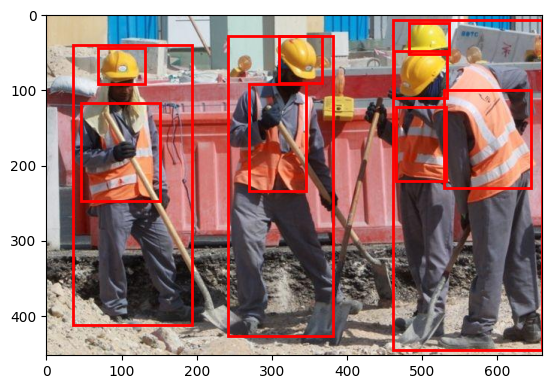

In [6]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def parse_yolo_line(line):
    # Leer txt
    data = line.strip().split(' ')
    class_index = int(data[0])
    x_center, y_center, width, height = map(float, data[1:])
    return class_index, x_center, y_center, width, height

def convert_yolo_to_xywh(image_shape, x_center, y_center, width, height):
    # (x, y, width, height)
    x = (x_center - width / 2) * image_shape[1]
    y = (y_center - height / 2) * image_shape[0]
    box_width = width * image_shape[1]
    box_height = height * image_shape[0]
    return x, y, box_width, box_height

def show_image_with_bounding_boxes(image_path, boxes_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    with open(boxes_path, 'r') as file:
        lines = file.readlines()

    # bbx en imagen
    fig, ax = plt.subplots(1)
    ax.imshow(image_rgb)

    for line in lines:
        class_index, x_center, y_center, width, height = parse_yolo_line(line)
        x, y, box_width, box_height = convert_yolo_to_xywh(image.shape, x_center, y_center, width, height)
        box = patches.Rectangle((x, y), box_width, box_height, linewidth=2, edgecolor='b', facecolor='none')
        ax.add_patch(box)

    plt.show()

show_image_with_bounding_boxes(image_path, boxes_path)


## Number of instances per class
